In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
#from datetime import date
#import time
#import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#from pandas.plotting import table
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

In [2]:
URL = 'https://worldometers.info/coronavirus/'

headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'}
page=requests.get(URL, headers=headers)
soup=BeautifulSoup(page.content, 'html.parser')

In [3]:
covid19_data = []   #initiate empty list to store data

web_table = soup.find('table')  #look for the table in web page

table_rows = web_table.find_all('tr')   #find rows

#iterate through rows and append contents of each row to the list
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    covid19_data.append(row)

covid19_data = covid19_data [1:] #remove blank/duplicate first row

In [4]:
# Get data from totals row. #Not needed, data available already within the panda df

tag = soup.find(class_="total_row")

total_rows = tag.find_all('td')
#print(total_rows)

total_row = [i.text for i in total_rows]
print(total_row)

#covid19_data.append(total_row)

['Total:', '613,828', '+17,516', '28,229', '+888', '137,223', '448,376', '23,995', '78.7', '3.6', '\n\xa0\n']


In [5]:
#convert data into a pandas data frame and insert headers
df = pd.DataFrame(covid19_data, columns = ['Country/Other', 'Total_Cases', 'New_Cases', 'Total_Deaths', 'New_Deaths', 'Total_Recovered', 'Active_Cases', 'Serious/Critical', 'Cases_per_1M', 'Deaths_per_1M', 'First_Case_Date']) 
#df.sort_values(by=['Total_Cases'])

In [6]:
#df.replace('', np.nan, inplace=True)
df.replace('', 0, inplace=True)  #replace all empty string with 0 (all except Total_Deaths)
df.replace(' ', 0, inplace=True) #replace  strings with just space with 0 (Total_Deaths)

df = df.drop(columns=['First_Case_Date']) #dropping 'First_Case_Date' column as it is not used later

df.tail()

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
197,Papua New Guinea,1,0,0,0,0,1,0,0.1,0
198,St. Vincent Grenadines,1,0,0,0,0,1,0,9,0
199,Timor-Leste,1,0,0,0,0,1,0,0.8,0
200,China,"81,394",+54,"3,295",+3,"74,971","3,128",886,57,2
201,Total:,"613,828","+17,516","28,229",+888,"137,223","448,376","23,995",78.7,3.6


In [7]:
#convert object types to float 64 type to plot graphs
df['Total_Cases'] = df['Total_Cases'].str.replace(',','').astype(np.float64)
df['New_Cases'] = df['New_Cases'].str.replace(',','').astype(np.float64)
df['Total_Deaths'] = df['Total_Deaths'].str.replace(',','').astype(np.float64)
df['New_Deaths'] = df['New_Deaths'].str.replace(',','').astype(np.float64)
df['Total_Recovered'] = df['Total_Recovered'].str.replace(',','').astype(np.float64)
df['Active_Cases'] = df['Active_Cases'].str.replace(',','').astype(np.float64)
df['Serious/Critical'] = df['Serious/Critical'].str.replace(',','').astype(np.float64)
df['Cases_per_1M'] = df['Cases_per_1M'].str.replace(',','').astype(np.float64)
df['Deaths_per_1M'] = df['Deaths_per_1M'].str.replace(',','').astype(np.float64)

#df.dtypes

In [8]:
df1 = df[:9] #take top 9 countries
df2 = df[9:-2] #avoid the 'total' row at the bottom

others = df2.sum(axis = 0, skipna = True)

others['Country/Other']='Others'
#print(others)

#print(len(df[10:]))
others['Cases_per_1M']=others['Cases_per_1M']/len(df2) #average the value
others['Deaths_per_1M']=others['Deaths_per_1M']/len(df2) #average the value
#print(others)


df1 = df1.append(others, ignore_index=True) #append all other countries ('others') to df1
#print(df1)
#plot = df1.plot.pie(y='Total_Cases', figsize=(5, 5))

df3=df1[['Country/Other','Total_Cases','Active_Cases','Total_Deaths']] #data in pie chart , used for inserting table in plot

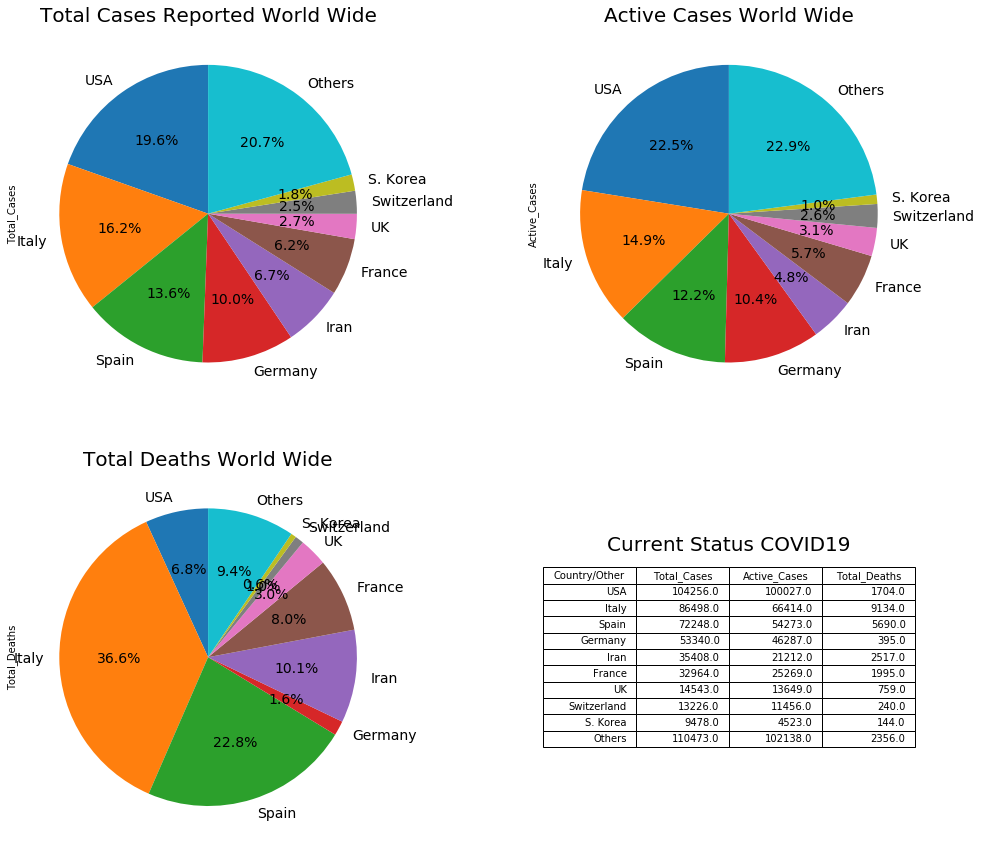

In [9]:
#plot pie charts

plt.figure(figsize=(16,12))

ax1 = plt.subplot(221, aspect='equal')
df1.plot(kind='pie', y = 'Total_Cases', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Cases Reported World Wide',fontsize=20)

ax2 = plt.subplot(222, aspect='equal')
df1.plot(kind='pie', y = 'Active_Cases', ax=ax2, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Active Cases World Wide',fontsize=20)

ax3 = plt.subplot(223, aspect='equal')
df1.plot(kind='pie', y = 'Total_Deaths', ax=ax3, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Deaths World Wide',fontsize=20)

#insert table in the plot
df3_text = []
for df3_row in range(len(df3)):
    df3_text.append(df3.iloc[df3_row])
plt.subplot(224)
plt.table(cellText=df3_text, colLabels=df3.columns, loc='center')
plt.axis('off')
plt.title('Current Status COVID19',fontsize=20, y=0.75)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.4)
plt.savefig('COVID19.png', dpi=300)
plt.show()


In [10]:
#send the plot as an email

right_now = str(datetime.datetime.now().strftime("%Y-%m-%d_%H:%M"))

# Open file with email details
file = open('email.txt',mode='r')
 
# read lines
all_lines = file.readlines()

# close the file
file.close()

email_user = all_lines[0]
email_password = all_lines[1]
email_send = all_lines[2]

subject = 'COVID19 Current Status'

msg = MIMEMultipart()
msg['From'] = email_user
msg['To'] = email_send
msg['Subject'] = subject

body = 'Hi, \n\nSending the status of COVID19 as of '+str(right_now)
msg.attach(MIMEText(body,'plain'))

filename='COVID19.png'
attachment  =open(filename,'rb')

part = MIMEBase('application','octet-stream')
part.set_payload((attachment).read())
encoders.encode_base64(part)
part.add_header('Content-Disposition',"attachment; filename= "+filename)

msg.attach(part)
text = msg.as_string()
server = smtplib.SMTP('smtp.gmail.com')
server.starttls()
server.login(email_user,email_password)


server.sendmail(email_user,email_send,text)
server.quit()

(221, b'2.0.0 closing connection y189sm12241379wmb.26 - gsmtp')